In [2]:
import imagenetscraper
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16, inception_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

%matplotlib inline

## Load Pre-trained Model

In [4]:
inception_model = inception_v3.InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

In [5]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

average_pooling2d_11 (AveragePo (None, 25, 25, 256)  0           mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 25, 25, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 25, 25, 64)   76800       activation_108[0][0]             
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 25, 25, 96)   82944       activation_111[0][0]             
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 25, 25, 64)   16384       average_pooling2d_11[0][0]       
__________________________________________________________________________________________________
batch_norm

conv2d_188 (Conv2D)             (None, 5, 5, 192)    393216      average_pooling2d_18[0][0]       
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 5, 5, 320)    960         conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 5, 5, 384)    0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
activation_183 (Activation)     (None, 5, 5, 384)    0           batch_normalization_183[0][0]    
__________________________________________________________________________________________________
activation_186 (Activation)     (None, 5, 5, 384)    0           batch_normalization_186[0][0]    
__________________________________________________________________________________________________
activation

## Prepare Dataset

In [ ]:
# in order to train a model for a different task we need to collect related datesets as defined below
!imagenetscraper n07756951 watermelon # http://image-net.org/synset?wnid=n07756951
!imagenetscraper n07734017 tomato
!imagenetscraper n07735510 pumpkin

## Setup The Data Generators

In [115]:
train_dir = './datasets/train/'
validation_dir = './datasets/validation/'
 
n_train = 600 # of total 3302
n_validation = 160 # of total 824

*Notice that batch size must match with the amount of train or validation!*

In [116]:
# change the batch size according to your system RAM
train_batch_size = 20
validation_batch_size = 20

#### Train dataset

In [32]:
# remember that the original image size is 224 x 224 and the last layer has a shape of 7 x 7 x 512
train_datagen = ImageDataGenerator(rescale=1./255)

train_features = np.zeros(shape=(n_train, 7, 7, 512)) #(600, 7, 7, 512)
train_labels = np.zeros(shape=(n_train, 3))
 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=train_batch_size,
    class_mode='categorical')

Found 3302 images belonging to 3 classes.


In [33]:
i = 0
for inputs_batch, labels_batch in train_generator:    
    features_batch = vgg_model.predict(inputs_batch)
    train_features[i * train_batch_size: (i+1) * train_batch_size] = features_batch
    train_labels[i * train_batch_size : (i+1) * train_batch_size] = labels_batch
    
    i+=1
    if i * train_batch_size >= n_train:
        break

In [34]:
train_features = np.reshape(train_features, (n_train, 7 * 7 * 512)) #(600, 25088)

#### Validation dataset

In [142]:
# remember that the original image size is 224 x 224 anfd the last layer has a shape of 7 x 7 x 512
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_features = np.zeros(shape=(n_validation, 7, 7, 512)) #(600, 7, 7, 512)
validation_labels = np.zeros(shape=(n_validation, 3))
 
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=validation_batch_size,
    class_mode='categorical')

Found 824 images belonging to 3 classes.


In [125]:
i = 0
for inputs_batch, labels_batch in validation_generator:    
    features_batch = vgg_model.predict(inputs_batch)
    validation_features[i * validation_batch_size: (i+1) * validation_batch_size] = features_batch
    validation_labels[i * validation_batch_size : (i+1) * validation_batch_size] = labels_batch

    i+=1
    if i * validation_batch_size >= n_validation:
        break

In [127]:
validation_features = np.reshape(validation_features, (n_validation, 7 * 7 * 512)) #(160, 25088)

## Create A New Model (Fully-connected Layers)

In [128]:
from keras import models
from keras import layers
from keras import optimizers
 
model_fcl = models.Sequential()
model_fcl.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model_fcl.add(layers.Dropout(0.5))
model_fcl.add(layers.Dense(3, activation='softmax'))

## Train The Model

In [140]:
model_fcl.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [141]:
history_fcl = model_fcl.fit(train_features,
                        train_labels,
                        epochs=40,
                        batch_size=20,
                        validation_data=(validation_features, validation_labels))

Train on 600 samples, validate on 160 samples
Epoch 1/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0259 - acc: 0.9917 - val_loss: 0.9706 - val_acc: 0.7563
Epoch 2/40
600/600 [==============================] - 3s 5ms/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.9601 - val_acc: 0.7375
Epoch 3/40
600/600 [==============================] - 3s 5ms/step - loss: 2.9528e-04 - acc: 1.0000 - val_loss: 0.9429 - val_acc: 0.7625
Epoch 4/40
600/600 [==============================] - 3s 5ms/step - loss: 2.0228e-04 - acc: 1.0000 - val_loss: 0.9890 - val_acc: 0.7437
Epoch 5/40
600/600 [==============================] - 3s 5ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.1412 - val_acc: 0.7437
Epoch 6/40
600/600 [==============================] - 3s 5ms/step - loss: 6.8851e-04 - acc: 1.0000 - val_loss: 1.1107 - val_acc: 0.7563
Epoch 7/40
600/600 [==============================] - 3s 5ms/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.9630 - val_acc: 0.7813
Epoch 8/40
600/600

## Check Performance

Text(0.5,1,'Loss Curves')

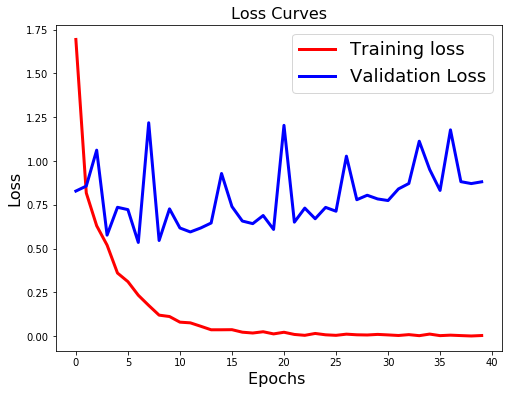

In [131]:
# plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_fcl.history['loss'],'r',linewidth=3.0)
plt.plot(history_fcl.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

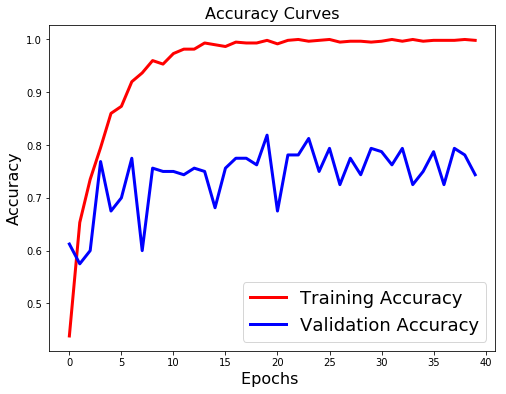

In [132]:
# plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_fcl.history['acc'],'r',linewidth=3.0)
plt.plot(history_fcl.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [133]:
fnames = validation_generator.filenames
ground_truth = validation_generator.classes

# getting the mapping from class index to class label
label_to_index = validation_generator.class_indices
idx_to_label = dict((v,k) for k,v in label_to_index.items())

In [134]:
predictions = model_fcl.predict_classes(validation_features)
probabilities = model_fcl.predict(validation_features)

In [135]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), n_validation))

No of errors = 1/160


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [136]:
fnames[errors[0]]

'pumpkin/008bcc2ee8e69719e93550eeaf5c7c8ed25efbc8.jpg'

Original label: pumpkin, Prediction: tomato, Confidence: 0.998


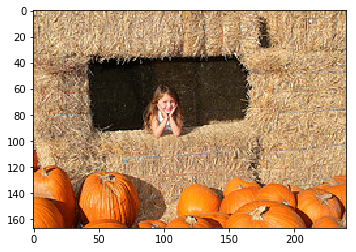

In [137]:
for i in range(len(errors)):
    prediction_class = np.argmax(probabilities[errors[i]])
    prediction_label = idx_to_label[prediction_class]
    
    print("Original label: {}, Prediction: {}, Confidence: {:.3f}".format(fnames[errors[i]].split('/')[0],
                                                                          prediction_label,
                                                                          probabilities[errors[i]][prediction_class]))
    
    original_image = load_img("{}{}".format(validation_dir, fnames[errors[i]]))
    plt.imshow(original_image)
    plt.show()

## Save The Model

In [138]:
# Save the model
model_fcl.save('models/fcl_transfer_learning.h5')

<hr/>